# Introduction to Statistical Learning Lab 3 - Linear Regression

This post is the first in a series where I work through [Intro to Statistical Learning](https://www.statlearning.com/) in python instead of R as done in the text. In this post I'll work through the lab for chapter 3, on linear regression. The second edition is coming in summer 2021, but I'm working through the first edition. You can find a free PDF [here](https://www.statlearning.com/s/ISLRSeventhPrinting.pdf).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot
import statsmodels.stats.outliers_influence as st_inf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn import preprocessing
%matplotlib inline

## 3.6.2 Simple Linear Regression

Load the Boston housing dataset and perform a basic regression. The book uses R. I'm going to use statsmodels and scikit-learn

In [2]:
df = sm.datasets.get_rdataset("Boston", "MASS", cache=True).data

In [3]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### scikit-learn implementation

Not happy that I had to do this weird reshape just because I only had one independent variable. Maybe there's a better way?

In [4]:
boston_skl_ols = LinearRegression(fit_intercept=True)
boston_skl_ols.fit(df["lstat"].to_numpy().reshape(-1, 1), df["medv"])
print("Coefficients: \n", boston_skl_ols.coef_)
print("Intercept: \n", boston_skl_ols.intercept_)

Coefficients: 
 [-0.95004935]
Intercept: 
 34.5538408793831


In [5]:
y_true = df["medv"]
y_pred = boston_skl_ols.predict(df['lstat'].to_numpy().reshape(-1, 1))
boston_skl_summary = {
    'R2': r2_score(y_true, y_pred), 
    'Ex. Var': explained_variance_score(y_true, y_pred), 
    'MSE': mean_squared_error(y_true, y_pred)
}

for k, v in boston_skl_summary.items():
    print(f"{k}: {v:0.2}")

R2: 0.54
Ex. Var: 0.54
MSE: 3.8e+01


I think I'll stick with StatsModels for the rest of this

### StatsModels Implementation

Where possible I prefer to use StatsModels. Scikit is great, and if I wanted to do a pure prediction I might prefer it, but StatsModels gives me all that analytic goodness I'm looking for.

#### Run regression and display basic summary stats

In [6]:
boston_sm_ols = sm.OLS(df["medv"], sm.add_constant(df["lstat"])).fit()
print(boston_sm_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Sat, 15 May 2021   Prob (F-statistic):           5.08e-88
Time:                        16:05:55   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.5538      0.563     61.415      0.0

A lot of the details are available in summary, but they can also be accessed using methods if you want to use them in further programming

In [7]:
boston_sm_ols.conf_int(alpha=0.05)

,0,1
const,33.448457,35.659225
lstat,-1.026148,-0.873951


Calculate confidence and prediction intervals for a set of independent variables (note the call to add_constant to include the intercept)

In [8]:
boston_sm_ols.get_prediction(sm.add_constant([5, 10, 15])).summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,29.803594,0.405247,29.007412,30.599776,17.565675,42.041513
1,25.053347,0.294814,24.474132,25.632563,12.827626,37.279068
2,20.303101,0.290893,19.731588,20.874613,8.077742,32.528459


To plot the regression there is a way to do it in StatsModels, but the nicer way is probably Seaborn, let's try both

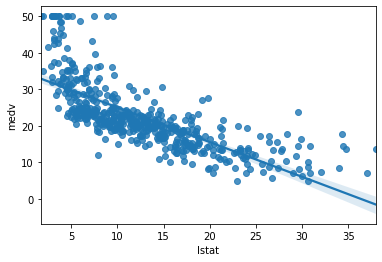

In [9]:
sns.regplot(x='lstat', y='medv', data=df);

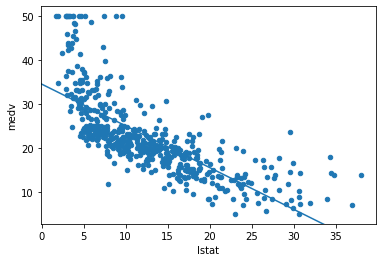

In [10]:
ax = df.plot(x='lstat', y='medv', kind='scatter')
abline_plot(model_results=boston_sm_ols, ax=ax);

Analyse residuals

In [11]:
# make a new dataframe for easier plotting
result_df = df[["lstat", "medv"]].copy()
result_df["fitted"] = boston_sm_ols.fittedvalues
result_df["resid"] = boston_sm_ols.resid

Basic residuals

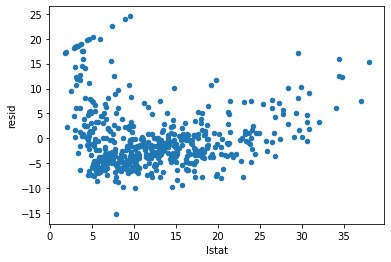

In [12]:
result_df.plot(x="lstat", y="resid", kind="scatter");

Plot leverage against studentized residuals

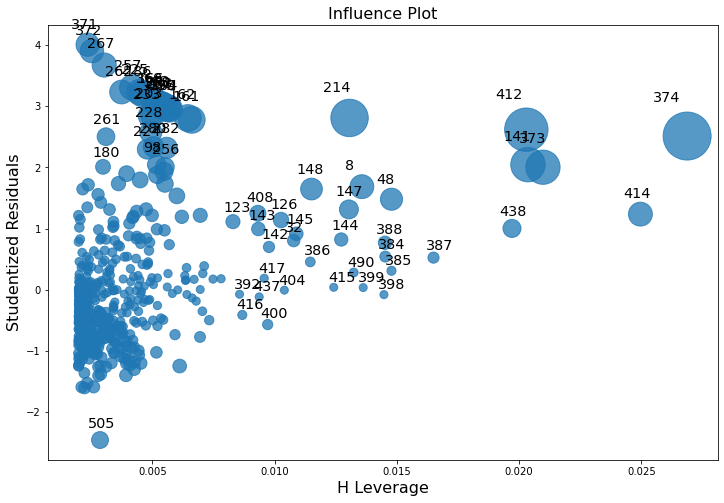

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(boston_sm_ols, ax=ax, criterion="cooks")

Can also get leverage and a bunch of other summary stats in numeric form, in ISL the lab shows which observation has the highest leverage

In [14]:
boston_influence = st_inf.OLSInfluence(boston_sm_ols).summary_frame()

In [15]:
boston_influence["hat_diag"].idxmax()

374

ISL returns 375 for this, but I'm guessing that's just because R counts from 1 and python indices are from 0

## 3.6.3 Multiple Linear Regression

Still using StatsModels, going to start using the same variable names as ISL going forward

In [16]:
lm = sm.OLS(df["medv"], sm.add_constant(df[["lstat", "age"]])).fit()

In [17]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Sat, 15 May 2021   Prob (F-statistic):           2.98e-88
Time:                        16:05:56   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.2228      0.731     45.458      0.0

In [18]:
X = df.drop(columns="medv")
y = df["medv"]
lm = sm.OLS(y, X).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:                   medv   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              891.3
Date:                Sat, 15 May 2021   Prob (F-statistic):                        0.00
Time:                        16:05:56   Log-Likelihood:                         -1523.8
No. Observations:                 506   AIC:                                      3074.
Df Residuals:                     493   BIC:                                      3128.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

More examples of accessing individual attributes. ISL pulls $R^2$ and RSE so I'll do the same

In [19]:
print(f"R squared: {lm.rsquared:0.3}, RSE: {lm.mse_resid:0.3}")

R squared: 0.959, RSE: 24.8


In [20]:
for col in X.columns:
    idx = list(X.columns).index(col)
    vif = st_inf.variance_inflation_factor(X.to_numpy(), idx)
    print(f"Variance Inflation Factor (VIF) for {col}: {vif:0.1}")

Variance Inflation Factor (VIF) for crim: 2e+00
Variance Inflation Factor (VIF) for zn: 3e+00
Variance Inflation Factor (VIF) for indus: 1e+01
Variance Inflation Factor (VIF) for chas: 1e+00
Variance Inflation Factor (VIF) for nox: 7e+01
Variance Inflation Factor (VIF) for rm: 8e+01
Variance Inflation Factor (VIF) for age: 2e+01
Variance Inflation Factor (VIF) for dis: 1e+01
Variance Inflation Factor (VIF) for rad: 2e+01
Variance Inflation Factor (VIF) for tax: 6e+01
Variance Inflation Factor (VIF) for ptratio: 9e+01
Variance Inflation Factor (VIF) for black: 2e+01
Variance Inflation Factor (VIF) for lstat: 1e+01


## 3.6.4 Interaction Terms and 3.6.5 Non-linear Transformations of Predictors

Calculate variance inflation factors for all the regressors:

In [21]:
for i, col in enumerate(X.columns):
    var_inf = st_inf.variance_inflation_factor(X.to_numpy(), i)
    print(f"VIF of {col}: {var_inf:0.2}")

VIF of crim: 2.1
VIF of zn: 2.8
VIF of indus: 1.4e+01
VIF of chas: 1.2
VIF of nox: 7.4e+01
VIF of rm: 7.8e+01
VIF of age: 2.1e+01
VIF of dis: 1.5e+01
VIF of rad: 1.5e+01
VIF of tax: 6.1e+01
VIF of ptratio: 8.5e+01
VIF of black: 2e+01
VIF of lstat: 1.1e+01


Interaction terms and non linear transformations

I know statsmodels can use R style formulas to define these transformations, but I prefer to do it manually, maybe I'm just oldschool

In [22]:
X["lstat_x_age"] = X["lstat"] * X["age"]
X["lstat_squared"] = X["lstat"]**2

In [23]:
print(sm.OLS(y, sm.add_constant(X[["lstat", "age", "lstat_x_age"]])).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     209.3
Date:                Sat, 15 May 2021   Prob (F-statistic):           4.86e-88
Time:                        16:05:56   Log-Likelihood:                -1635.0
No. Observations:                 506   AIC:                             3278.
Df Residuals:                     502   BIC:                             3295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          36.0885      1.470     24.553      

In [24]:
print(sm.OLS(y, sm.add_constant(X[["lstat", "lstat_squared"]])).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Sat, 15 May 2021   Prob (F-statistic):          1.56e-112
Time:                        16:05:56   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            42.8620      0.872     49.149

ANOVA to compare linear and quadratric models

In [25]:
linear_ols = sm.OLS(y, sm.add_constant(X["lstat"])).fit()
quad_ols = sm.OLS(y, sm.add_constant(X[["lstat", "lstat_squared"]])).fit()
sm.stats.anova_lm(linear_ols, quad_ols)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,504.0,19472.381418,0.0,NaN,NaN,NaN
1,503.0,15347.243158,1.0,4125.13826,135.199822,7.630116e-28


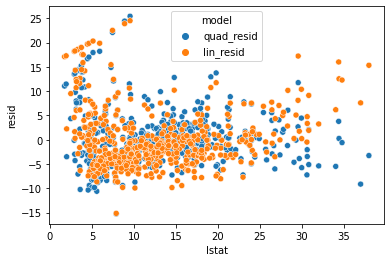

In [26]:
result_df = df[["lstat", "medv"]].copy()
result_df["quad_fitted"] = quad_ols.fittedvalues
result_df["quad_resid"] = quad_ols.resid
result_df["lin_fitted"] = linear_ols.fittedvalues
result_df["lin_resid"] = linear_ols.resid
cdf = result_df[["lstat", "quad_resid", "lin_resid"]].melt(id_vars="lstat", var_name="model", value_name="resid")
sns.scatterplot(x="lstat", y="resid", hue="model", data=cdf);

Sure we've improved the fit, but I don't see it as such a drastic improvement like the text claims

Higher order polynomials

In [27]:
X_poly = sm.add_constant(X["lstat"]).copy()
for i in range(2, 6):
    new_name = "lstat_pow_" + str(i)
    X_poly[new_name] = X_poly["lstat"]**i
poly_ols = sm.OLS(y, X_poly).fit()
print(poly_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     214.2
Date:                Sat, 15 May 2021   Prob (F-statistic):          8.73e-122
Time:                        16:05:57   Log-Likelihood:                -1550.6
No. Observations:                 506   AIC:                             3113.
Df Residuals:                     500   BIC:                             3139.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          67.6997      3.604     18.783      

Ok, that's way different than the book. The actual model fit is fine, but the coefficients are different. Further reading indicates that poly in R does an orthogonal polynomial. Quick googling didn't turn up any baked in way to compute that in python, but I found [this post](http://davmre.github.io/blog/python/2013/12/15/orthogonal_poly) that gives a method. Let's try that.

In [28]:
def ortho_poly_fit(x, degree = 1):
    n = degree + 1
    x = np.asarray(x).flatten()
    if(degree >= len(np.unique(x))):
            stop("'degree' must be less than number of unique points")
    xbar = np.mean(x)
    x = x - xbar
    X = np.fliplr(np.vander(x, n))
    q,r = np.linalg.qr(X)

    z = np.diag(np.diag(r))
    raw = np.dot(q, z)

    norm2 = np.sum(raw**2, axis=0)
    alpha = (np.sum((raw**2)*np.reshape(x,(-1,1)), axis=0)/norm2 + xbar)[:degree]
    Z = raw / np.sqrt(norm2)
    return Z, norm2, alpha

def ortho_poly_predict(x, alpha, norm2, degree = 1):
    x = np.asarray(x).flatten()
    n = degree + 1
    Z = np.empty((len(x), n))
    Z[:,0] = 1
    if degree > 0:
        Z[:, 1] = x - alpha[0]
    if degree > 1:
      for i in np.arange(1,degree):
          Z[:, i+1] = (x - alpha[i]) * Z[:, i] - (norm2[i] / norm2[i-1]) * Z[:, i-1]
    Z /= np.sqrt(norm2)
    return Z

In [29]:
lstat = X["lstat"]
X_poly, _, _ = ortho_poly_fit(lstat, degree=5)
poly_ols = sm.OLS(y, sm.add_constant(X_poly[:, 1:])).fit()
print(poly_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     214.2
Date:                Sat, 15 May 2021   Prob (F-statistic):          8.73e-122
Time:                        16:05:57   Log-Likelihood:                -1550.6
No. Observations:                 506   AIC:                             3113.
Df Residuals:                     500   BIC:                             3139.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.5328      0.232     97.197      0.0

Ok, that fits now. The first column in the returned array is a weirdly scaled intercept, which is why I had to drop that column and add a constant back in... 
Not super elegant, but it does get the job done

Got the idea for these plots from https://github.com/emredjan/ISL-python

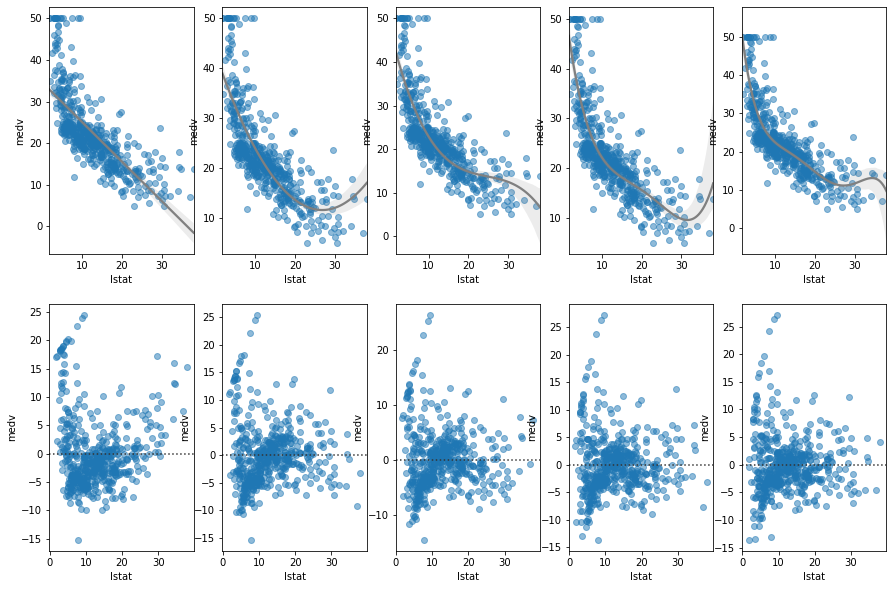

In [30]:
fig, ax = plt.subplots(2, 5, sharex=False, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

for col in range(5):
    order = col + 1
    for row, plotfunc in enumerate([sns.regplot, sns.residplot]):
        plotfunc(x="lstat", y="medv", data=df, ax=ax[row, col], order=order, line_kws={"color": "gray"}, scatter_kws={"alpha": 0.5})

## 3.6.6 Qualitative Predictors

In [31]:
df = sm.datasets.get_rdataset("Carseats", "ISLR", cache=True).data
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [32]:
try:
    car_ols = smf.ols(formula="Sales ~ . + Income : Advertising + Price : Age", data=df).fit()
except SyntaxError:
    print("Doesn't like the dot operator")

Doesn't like the dot operator


In [33]:
X = (
    pd.concat([
        df[["CompPrice", "Income", "Advertising", "Population", "Price", "Age", "Education"]],
        pd.get_dummies(df["ShelveLoc"], prefix="Shelf", drop_first=True),
        pd.get_dummies(df["Urban"], prefix="Urban", drop_first=True),
        pd.get_dummies(df["US"], prefix="US", drop_first=True),
    ], axis="columns")
    .pipe(sm.add_constant)
    .assign(income_x_advertising=lambda df: df["Income"] * df["Advertising"])
    .assign(price_x_age=lambda df: df["Price"] * df["Age"])
)
y = df["Sales"]
car_ols = sm.OLS(y, X).fit()
print(car_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     210.0
Date:                Sat, 15 May 2021   Prob (F-statistic):          6.14e-166
Time:                        16:05:58   Log-Likelihood:                -564.67
No. Observations:                 400   AIC:                             1157.
Df Residuals:                     386   BIC:                             1213.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.5756 